# kettler analysis

## intro code

In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
from textwrap import wrap
import plotly.express as px
import datetime as dt
import requests

exec(requests.get(
    'https://gist.githubusercontent.com/smeisegeier/4944b9a88b7a90cb1b2acc6da0dd906f/raw/'
    ).text)

# * get src directory which *must* be parent
dir_src = Path(os.getcwd()).parent.parent

# # * add to path
# if dir_src.as_posix() not in sys.path:
#     sys.path.append(dir_src.as_posix())

# * display / style settings
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 160
pd.options.display.precision = 2


# * theme settings
THEME = "dark" # 'light'

if THEME == 'dark':
    THEME_PLOTLY="plotly_dark"
else:
    THEME_PLOTLY="plotly"

## load data

In [2]:
df_training=pd.read_parquet('data/trainings.pq')
df_records=pd.read_parquet('data/records.pq')

## analysis

In [22]:
describe_df(df_training.iloc[:,1:], 'training', use_columns=False, use_plot=False)

*** training ***
shape: (1_119, 13) columns: ['Device', 'Calibration', 'Software', 'Date', 'Time', 'RecordIntervall', 'Transmission', 'Energy', 'TrainingDateTime', 'FileName', 'CreatedAt', 'Duration_minutes', 'Streak_days'] 
duplicates: 0
***
Duration_minutes(114|float64) min: 0.667 | max: 73.833 | median: 30.0 | mean: 32.33 | std: 6.61 | cv: 0.204 | sum: 36_181.833 | skew: 2.57 | kurto: 10.938
Streak_days(13|int64) min: 0 | max: 23 | median: 1.0 | mean: 1.0 | std: 1.69 | cv: 1.69 | sum: 1_120 | skew: 5.512 | kurto: 51.997
missings: {'Device': 0, 'Calibration': 0, 'Software': 0, 'Date': 0, 'Time': 0, 'RecordIntervall': 0, 'Transmission': 0, 'Energy': 0, 'TrainingDateTime': 0, 'FileName': 0, 'CreatedAt': 0, 'Duration_minutes': 0, 'Streak_days': 0}


,Device,Calibration,Software,Date,Time,RecordIntervall,Transmission,Energy,TrainingDateTime,FileName,CreatedAt,Duration_minutes,Streak_days
0,SJ10X SKYLON 5,07655-350-2007,3367,11.01.2014,20:09:26,10,9.5,6.0,2014-01-11T20:09:26+01:00,Training 11.01.2014 20h09m26s.xml,2021-01-07 23:58:46.053121,53.17,0
1,SJ10X SKYLON 5,07655-350-2007,3367,12.01.2014,18:49:44,10,9.5,6.0,2014-01-12T18:49:44+01:00,Training 12.01.2014 18h49m44s.xml,2021-01-07 23:58:46.053121,56.67,0
2,SJ10X SKYLON 5,07655-350-2007,3367,13.01.2014,21:56:13,10,9.5,6.0,2014-01-13T21:56:13+01:00,Training 13.01.2014 21h56m13s.xml,2021-01-07 23:58:46.053121,59.17,0


*** records ***
shape: (217_091, 7) columns: ['Pulse', 'Power', 'RPM', 'TimePassed_minutes', 'TimePassed_percent', 'Score_10sec', 'TrainingId'] 
duplicates: 0
***
Pulse(182|int64) min: 0 | max: 220 | median: 77.0 | mean: 65.01 | std: 64.19 | cv: 0.987 | sum: 14_112_954 | skew: 0.099 | kurto: -1.737
Power(52|int64) min: 25 | max: 300 | median: 160.0 | mean: 160.17 | std: 23.31 | cv: 0.146 | sum: 34_770_490 | skew: -0.635 | kurto: 2.301
RPM(61|int64) min: 14 | max: 89 | median: 54.0 | mean: 53.63 | std: 3.56 | cv: 0.066 | sum: 11_642_478 | skew: -0.813 | kurto: 6.273
TimePassed_minutes(443|float64) min: 0.167 | max: 73.833 | median: 16.33 | mean: 16.92 | std: 10.77 | cv: 0.637 | sum: 3_674_194.833 | skew: 0.694 | kurto: 0.854
TimePassed_percent(23_272|float64) min: 0.002 | max: 1.0 | median: 0.5 | mean: 0.5 | std: 0.29 | cv: 0.574 | sum: 109_105.0 | skew: -0.0 | kurto: -1.2
Score_10sec(1_028|float64) min: 0.0 | max: 0.018 | median: 0.01 | mean: 0.01 | std: 0.0 | cv: 0.186 | sum: 1_602.26

,Pulse,Power,RPM,TimePassed_minutes,TimePassed_percent,Score_10sec,TrainingId
0,0,50,46,0.17,3.13e-03,1.97e-03,1
1,0,150,45,36.17,6.80e-01,5.77e-03,1
2,0,150,49,36.00,6.77e-01,6.28e-03,1


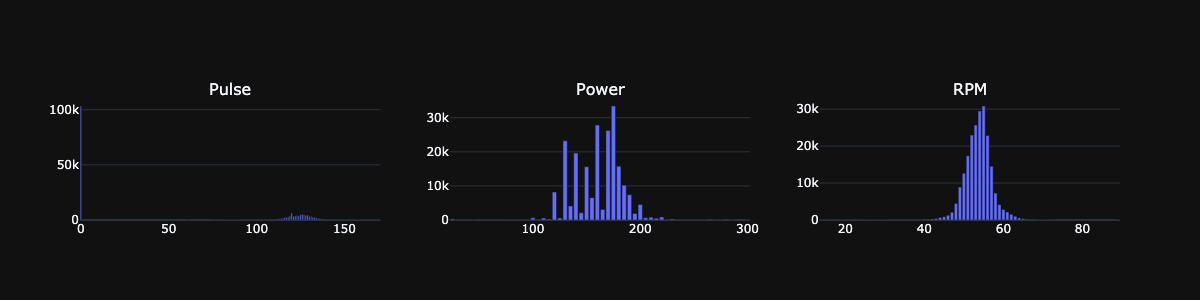

In [21]:
describe_df(df_records.iloc[:,1:], 'records', use_columns=False, fig_offset=-4)

In [25]:
#
# * tailor and join both tables

# * id col is new index
if "Id" in df_training.columns:
    df_training.set_index("Id", inplace=True, drop=True)
if "Id" in df_records.columns:
    df_records.set_index("Id", inplace=True, drop=True)

# * convert to proper datetime (remove 'T')
df_training.TrainingDateTime=pd.to_datetime(df_training.TrainingDateTime, errors='coerce')

df_training['daytime']=df_training.TrainingDateTime.dt.hour.map(
    lambda x: "morning" if x < 13 else "day" if x < 18 else "evening"
)

# * add day_of_week
df_training['day_of_week']=df_training.TrainingDateTime.dt.strftime('%A')

# * join both tables on records level
df=df_records.join(df_training, on="TrainingId")
df

# * drop unneeded columns: filename, createdat, TrainingId
col_one_item = [col for col in df if len(df[col].unique()) == 1]
print(f"remove these one-item columns:{col_one_item}")

df.drop(
    # * subtract columns to make the statement idempotent
    columns=set(df.columns)
    & (set(["FileName", "CreatedAt", "TrainingId"]) | set(col_one_item)),
    inplace=True,
)

df[:3]

remove these one-item columns:['Device', 'Calibration', 'Software', 'RecordIntervall', 'Transmission', 'Energy']


,Pulse,Power,RPM,TimePassed_minutes,TimePassed_percent,Score_10sec,Date,Time,TrainingDateTime,Duration_minutes,Streak_days,daytime,day_of_week
Id,,,,,,,,,,,,,
1,0,50,46,0.17,3.13e-03,1.97e-03,11.01.2014,20:09:26,2014-01-11 20:09:26+01:00,53.17,0,evening,Saturday
2,0,150,45,36.17,6.80e-01,5.77e-03,11.01.2014,20:09:26,2014-01-11 20:09:26+01:00,53.17,0,evening,Saturday
3,0,150,49,36.00,6.77e-01,6.28e-03,11.01.2014,20:09:26,2014-01-11 20:09:26+01:00,53.17,0,evening,Saturday


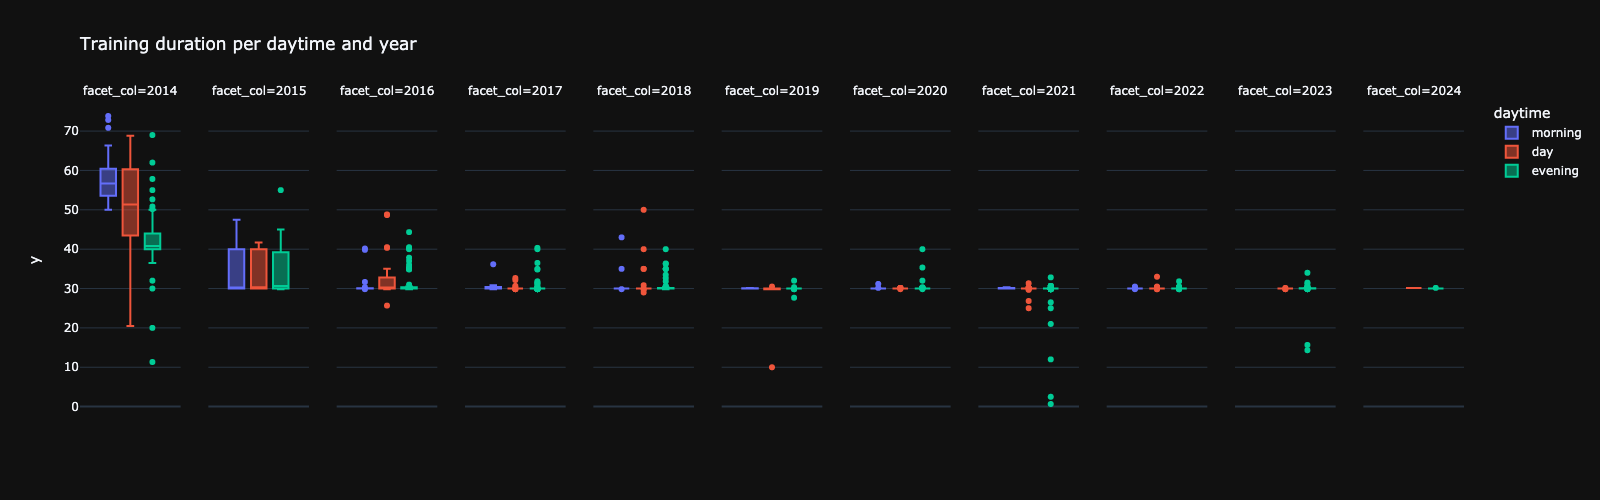

In [87]:
_df = df_training
# * add aux cols for sorting
_df['_daytime'] = pd.Categorical(_df.daytime, ["morning", "day", "evening"])
_df['_year'] = _df.TrainingDateTime.dt.year

_fig = px.box(
    _df.sort_values(by=["_year","_daytime"]),
    y=_df.Duration_minutes,
    template=THEME_PLOTLY,
    color='daytime',
    points="outliers",
    # points=False,
    facet_col=_df.TrainingDateTime.dt.year,
    # height=300,
    width=1600,
    title="Training duration per daytime and year",
    )
_fig.show('png')

In [88]:
print('TOP 10 streak days')
df_training.assign(_year=df_training.TrainingDateTime.dt.year).sort_values(by='Streak_days', ascending=False)[['Streak_days','Date','_year']][:10]

TOP 10 streak days


,Streak_days,Date,_year
Id,,,
493,23,02.07.2018,2018
773,19,15.01.2021,2021
944,19,05.05.2022,2022
380,12,08.01.2017,2017
454,12,23.12.2017,2017
694,10,07.11.2020,2020
980,9,28.10.2022,2022
918,9,22.03.2022,2022
466,7,26.10.2017,2017
